# 9-1. 프로젝트: CAM을 만들고 평가해 보자


## 라이브러리 버전 확인하기

사용할 라이브러리 버전을 확인해봐요.


In [60]:
# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_datasets as tfds

import copy
import cv2
from PIL import Image

print('슝=3')

슝=3


In [61]:
tf.config.list_physical_devices('GPU')

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [62]:
# 최초 수행시에는 다운로드가 진행됩니다. 오래 걸릴 수 있으니 유의해 주세요.  
(ds_train, ds_test), ds_info = tfds.load(
    'stanford_dogs',
    split=['train', 'test'],
    shuffle_files=True,
    with_info=True,
)
print('슝=3')

슝=3


In [63]:
num_classes = ds_info.features["label"].num_classes

base_model = keras.applications.resnet50.ResNet50(
    include_top=False,    # Imagenet 분류기  fully connected layer 제거
    weights='imagenet',
    input_shape=(224, 224, 3),
    pooling='avg',      # GAP를 적용  
)
x = base_model.output
preds = keras.layers.Dense(units=num_classes, activation='softmax')(x)
cam_model = keras.Model(inputs=base_model.input, outputs=preds)
cam_model.summary()

Model: "model_24"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv1_pad (ZeroPadding2D)   (None, 230, 230, 3)          0         ['input_1[0][0]']             
                                                                                                  
 conv1_conv (Conv2D)         (None, 112, 112, 64)         9472      ['conv1_pad[0][0]']           
                                                                                                  
 conv1_bn (BatchNormalizati  (None, 112, 112, 64)         256       ['conv1_conv[0][0]']          
 on)                                                                                       

In [64]:
def normalize_and_resize_img(input):
    # Normalizes images: `uint8` -> `float32`
    image = tf.image.resize(input['image'], [224, 224])
    input['image'] = tf.cast(image, tf.float32) / 255.
    return input['image'], input['label']

def apply_normalize_on_dataset(ds, is_test=False, batch_size=16):
    ds = ds.map(
        normalize_and_resize_img, 
        num_parallel_calls=2
    )
    ds = ds.batch(batch_size)
    '''
    if not is_test:
        ds = ds.repeat()
        ds = ds.shuffle(200)
    '''
    ds = ds.prefetch(tf.data.experimental.AUTOTUNE)
    return ds


In [65]:
# 데이터셋에 전처리와 배치처리를 적용합니다.
ds_train_norm = apply_normalize_on_dataset(ds_train)
ds_val_norm = apply_normalize_on_dataset(ds_test)

# 구성된 배치의 모양을 확인해 봅니다. 
for input in ds_train_norm.take(1):
    image, label = input
    print(image.shape)
    print(label.shape)

(16, 224, 224, 3)
(16,)


In [66]:
cam_model.compile(
    loss='sparse_categorical_crossentropy',
    # optimizer=tf.keras.optimizers.SGD(learning_rate=0.01),
    optimizer=tf.keras.optimizers.legacy.SGD(learning_rate=0.01), # for Apple Silicon prevent delaying
    metrics=['accuracy'],
)

print('슝=3')

슝=3


In [67]:
history_cam_model = cam_model.fit(
    ds_train_norm,
    steps_per_epoch=int(ds_info.splits['train'].num_examples/16),
    validation_steps=int(ds_info.splits['test'].num_examples/16),
    epochs=2,
    validation_data=ds_val_norm,
    verbose=1,
    use_multiprocessing=True,
)

Epoch 1/2


2024-07-05 16:52:21.409607: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - ETA: 0s - loss: 2.2365 - accuracy: 0.4377

2024-07-05 16:56:18.349274: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


750/750 [==============================] - 274s 346ms/step - loss: 2.2365 - accuracy: 0.4377 - val_loss: 3.5841 - val_accuracy: 0.1747
Epoch 2/2
750/750 [==============================] - 273s 364ms/step - loss: 0.7400 - accuracy: 0.7920 - val_loss: 1.2600 - val_accuracy: 0.6328


In [74]:
# Q. '/aiffel/class_activation_map' 에 'cam_model1.h5'을 저장하세요.

import os

cam_model_path = "./class_activation_map/cam_model.h5"

cam_model.save(cam_model_path, save_format='h5')

/opt/homebrew/Caskroom/miniforge/base/envs/py38/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


## CAM 구현하기

In [75]:
import os
# cam_model_path = os.getenv('HOME')+'/aiffel/class_activation_map/cam_model.h5'
cam_model = tf.keras.models.load_model(cam_model_path)


1. 이번 노드에 나왔던 CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

In [76]:
# not a batch, just pick a image
def get_one(ds):
    ds = ds.take(1)
    sample_data = list(ds.as_numpy_iterator())
    bbox = sample_data[0]['objects']['bbox']
    image = sample_data[0]['image']
    label = sample_data[0]['label']
    return sample_data[0]


In [77]:
def generate_cam(model, item): # item : 시각화 할 image
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # 학습한 모델에서 원하는 Layer의 output을 얻기 위해서 모델의 input과 output을 새롭게 정의해줍니다.
    cam_model = tf.keras.models.Model([model.inputs], [model.layers[-3].output, model.output])
    # [-3] : Feature map (after convolution) [-2] : Pooling(GAP), [-1] : Classifier
    conv_outputs, predictions = cam_model(tf.expand_dims(img_tensor, 0)) # 3차원을 4차원으로 늘임(배치단위를 1로)
    conv_outputs = conv_outputs[0, :, :, :] # (1, 7, 7, 2048) -> (7, 7, 2048)
    
    # 모델의 weight activation은 마지막 layer에 있습니다.
    class_weights = model.layers[-1].get_weights()[0] # 가중치[0], bias[1]
    
    cam_image = np.zeros(dtype=np.float32, shape=conv_outputs.shape[0:2]) # (7, 7)
    for i, w in enumerate(class_weights[:, class_idx]): # 각 클래스 별 가중치를 순회하면서
        
        # conv_outputs의 i번째 채널과 i번째 weight를 곱해서 누적하면 활성화된 정도가 나타날 겁니다.
        # 피쳐맵 결과와 클래스 별 가중치 곱을 누적
        cam_image += w * conv_outputs[:, :, i]

    cam_image /= np.max(cam_image) # activation score를 normalize합니다.
    cam_image = cam_image.numpy()
    cam_image = cv2.resize(cam_image, (width, height)) # 원래 이미지의 크기로 resize합니다.
    return cam_image


40


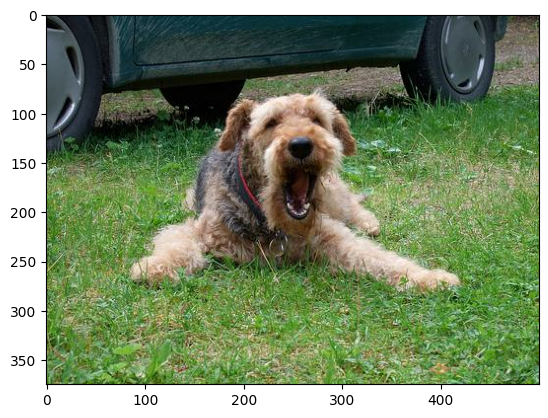

In [78]:
item = get_one(ds_test)
print(item['label'])
plt.imshow(item['image'])
plt.show()

2. 만든 함수로 CAM 이미지를 생성합시다.

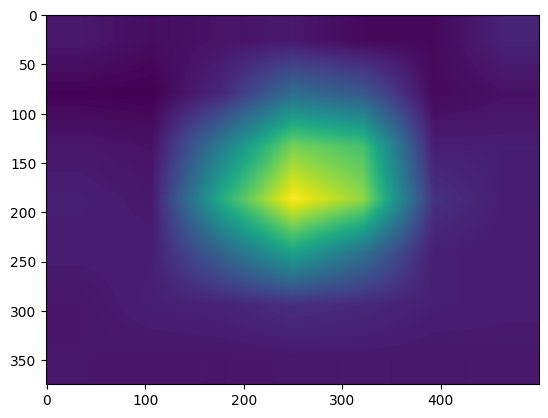

In [79]:
cam_image = generate_cam(cam_model, item)
plt.imshow(cam_image)


3. 원본 이미지와 CAM 이미지를 입력으로 받고 두 개의 이미지의 투명도를 조정, 하나의 이미지에서 원본과 CAM을 겹쳐 보여주는 visualize_cam_on_image() 함수를 만들어보세요.

[webnautes님의 OpenCV Python 강좌 - 두 개의 이미지 더하기, 블렌딩](https://webnautes.tistory.com/1245)

In [80]:
def visualize_cam_on_image(src1, src2, alpha=0.5):
    beta = (1.0 - alpha)
    merged_image = cv2.addWeighted(src1, alpha, src2, beta, 0.0) # 자연스럽게 합쳐준다. 
    return merged_image

/var/folders/wc/pnwgj_r56fj5svm2hq2_8x4m0000gn/T/ipykernel_70518/818415003.py:5: RuntimeWarning: invalid value encountered in cast
  cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8) # 2차원 데이터(W * H) - 3채널로 만들기 - (W, H, 3)


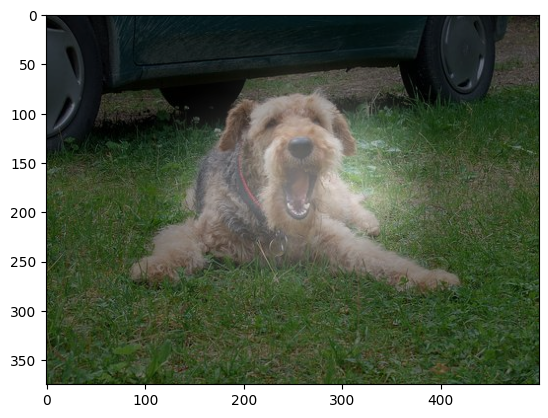

In [81]:

# visualize_cam_on_image() 함수 사용


origin_image = item['image'].astype(np.uint8) 
cam_image_3channel = np.stack([cam_image*255]*3, axis=-1).astype(np.uint8) # 2차원 데이터(W * H) - 3채널로 만들기 - (W, H, 3)

blended_image = visualize_cam_on_image(cam_image_3channel, origin_image)
plt.imshow(blended_image)
plt.show()

40


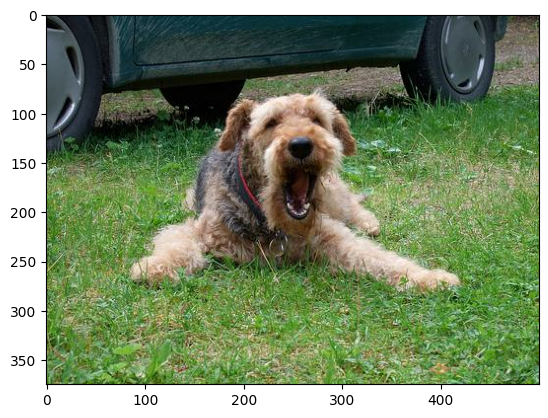

In [82]:
grad_item = get_one(ds_test)
print(grad_item['label'])
plt.imshow(grad_item['image'])
plt.show()


## Grad-CAM 구현하기



1. 이번 노드에 나왔던 Grad-CAM을 직접 구현해 봅시다. 예제 코드를 최대한 보지 말고, 설명과 이론을 보고 구현해 보세요.

In [83]:
def generate_grad_cam(model, activation_layer, item):
    item = copy.deepcopy(item)
    width = item['image'].shape[1]
    height = item['image'].shape[0]
    img_tensor, class_idx = normalize_and_resize_img(item)
    
    # Grad cam에서도 cam과 같이 특정 레이어의 output을 필요로 하므로 모델의 input과 output을 새롭게 정의합니다.
    # 이때 원하는 레이어가 다를 수 있으니 해당 레이어의 이름으로 찾은 후 output으로 추가합니다.
    grad_model = tf.keras.models.Model([model.inputs], [model.get_layer(activation_layer).output, model.output])
    
    # Gradient를 얻기 위해 tape를 사용합니다.
    with tf.GradientTape() as tape:
        conv_output, pred = grad_model(tf.expand_dims(img_tensor, 0))
    
        loss = pred[:, class_idx] # 원하는 class(여기서는 정답으로 활용) 예측값을 얻습니다. 
        # print(pred.shape, loss.shape) # (1, 120), (1,)
        output = conv_output[0] # 원하는 layer의 output을 얻습니다. # 3차원
        grad_val = tape.gradient(loss, conv_output)[0] # 예측값에 따른 Layer의 gradient를 얻습니다.
        
    # print(grad_val.shape) # (7, 7, 2048)

    weights = np.mean(grad_val, axis=(0, 1)) # gradient의 GAP으로 weight를 구합니다. (7, 7) -> (1)
    # print(weights.shape) # 2048 : filter 
    
    grad_cam_image = np.zeros(dtype=np.float32, shape=conv_output.shape[0:2])
    for k, w in enumerate(weights):
        # output의 k번째 채널과 k번째 weight를 곱하고 누적해서 class activation map을 얻습니다.
        grad_cam_image += w * output[:, :, k]
        
    grad_cam_image = tf.math.maximum(0, grad_cam_image)
    grad_cam_image /= np.max(grad_cam_image)
    grad_cam_image = grad_cam_image.numpy()
    grad_cam_image = cv2.resize(grad_cam_image, (width, height))
    return grad_cam_image


2. 만든 함수로 여러 레이어의 CAM 이미지를 뽑아서 직접 확인해 보세요.


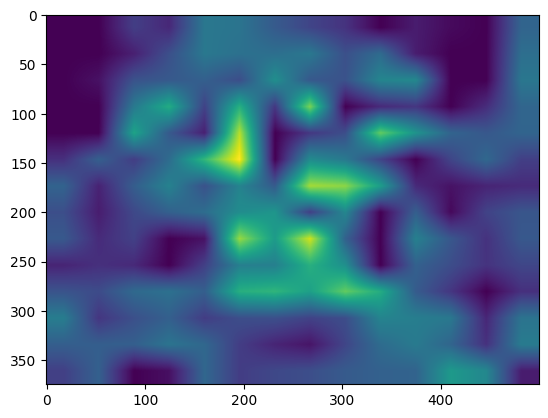

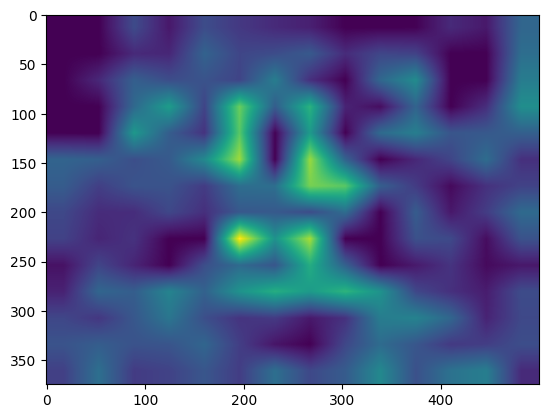

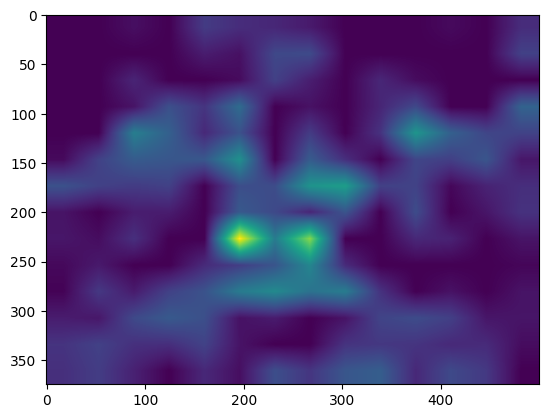

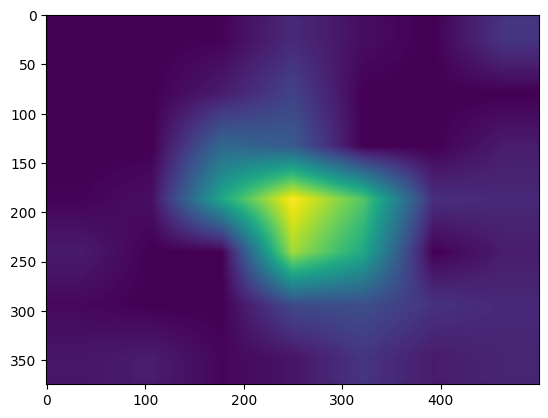

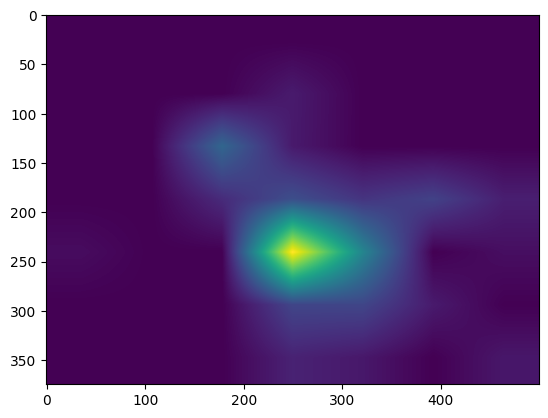

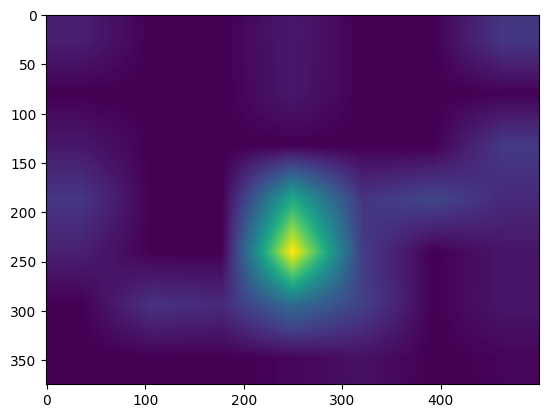

In [86]:
for i in [4, 5]:
    for j in range(3):
        grad_cam_image = generate_grad_cam(cam_model, f'conv{i}_block{j+1}_out', item)
        plt.imshow(grad_cam_image)
        plt.show()

3. 위에서 만든 이미지 visualize_cam_on_image() 함수로 이미지를 시각화해 보세요.


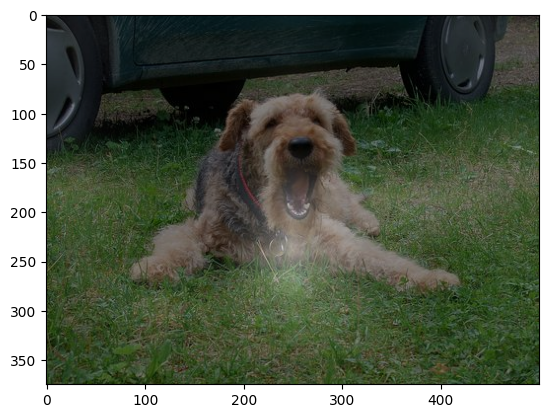

In [87]:
grad_origin_image = grad_item['image'].astype(np.uint8) 
grad_cam_image_3channel = np.stack([grad_cam_image*255]*3, axis=-1).astype(np.uint8) # 2차원 데이터(W * H) - 3채널로 만들기 - (W, H, 3)

grad_blended_image = visualize_cam_on_image(grad_cam_image_3channel, grad_origin_image)
plt.imshow(grad_blended_image)
plt.show()


## 바운딩 박스 구하기


1. 제시된 코드를 참고해, 직접 Grad-CAM으로 얻은 CAM을 통해서 바운딩 박스를 얻어보세요.

2. 1)에서 얻은 바운딩 박스를 시각화해 보세요.


In [88]:
def get_bbox(cam_image, score_thresh=0.05):
    low_indicies = cam_image <= score_thresh
    cam_image[low_indicies] = 0
    cam_image = (cam_image*255).astype(np.uint8)
    
    contours,_ = cv2.findContours(cam_image, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    cnt = contours[0]
    rotated_rect = cv2.minAreaRect(cnt)
    rect = cv2.boxPoints(rotated_rect)
    rect = np.int0(rect)
    return rect


In [89]:
grad_rect = get_bbox(grad_cam_image)
grad_rect

/var/folders/wc/pnwgj_r56fj5svm2hq2_8x4m0000gn/T/ipykernel_70518/1737992177.py:10: DeprecationWarning: `np.int0` is a deprecated alias for `np.intp`.  (Deprecated NumPy 1.24)
  rect = np.int0(rect)


array([[ -8, 122],
       [498,  92],
       [512, 333],
       [  5, 363]])

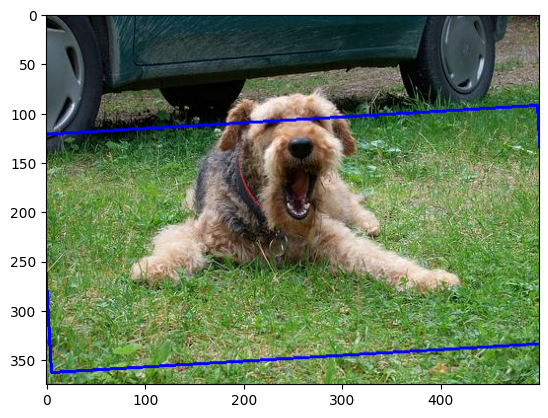

In [90]:
grad_image = copy.deepcopy(grad_item['image'])
grad_image = cv2.drawContours(grad_image, [grad_rect], 0, (0,0,255), 2) # 이미지, 사각형정보(리스트), 사각형인덱스, 색상, 두께
plt.imshow(grad_image)
plt.show()

In [91]:
# rect의 좌표는 (x, y) 형태로, bbox는 (y_min, x_min, y_max, x_max)의 normalized 형태로 주어집니다. 
def rect_to_minmax(rect, image):
    bbox = [
        rect[:,1].min()/float(image.shape[0]),  #bounding box의 y_min
        rect[:,0].min()/float(image.shape[1]),  #bounding box의 x_min
        rect[:,1].max()/float(image.shape[0]), #bounding box의 y_max
        rect[:,0].max()/float(image.shape[1]) #bounding box의 x_max
    ]
    return bbox


In [92]:
# translate "rect" calculated, to bbox
grad_pred_bbox = rect_to_minmax(grad_rect, grad_item['image'])
grad_pred_bbox

[0.24533333333333332, -0.016, 0.968, 1.024]

In [93]:
grad_item['objects']['bbox'] #ground truth

array([[0.192, 0.168, 0.76 , 0.838]], dtype=float32)


## IoU 구하기



1. 정답 바운딩 박스(ground truth) 와 예측값 바운딩 박스(prediction box) 두 가지를 이용해서 IoU를 계산하는 get_iou() 함수를 만들어 주세요.


In [94]:
def get_iou(boxA, boxB):
    y_min = max(boxA[0], boxB[0])
    x_min= max(boxA[1], boxB[1])
    y_max = min(boxA[2], boxB[2])
    x_max = min(boxA[3], boxB[3])
    
    interArea = max(0, x_max - x_min) * max(0, y_max - y_min)
    boxAArea = (boxA[2] - boxA[0]) * (boxA[3] - boxA[1])
    boxBArea = (boxB[2] - boxB[0]) * (boxB[3] - boxB[1])
    iou = interArea / float(boxAArea + boxBArea - interArea)

    return iou


In [96]:
grad_iou = get_iou(grad_pred_bbox, item['objects']['bbox'][0])
grad_iou

0.43798267283676595

CAM과 Grad-CAM으로 얻은 바운딩 박스와 정답 바운딩 박스와의 IoU를 각각 비교해 봅시다.

- CAM_Practice에서 마지막에 산출한 결과 (CAM_IoU) : 0.6564966811419951
- CAM_Project에서 마지막에 산출한 결과 (Grad_CAM_IoU) : 0.43798267283676595

# 회고

- CAM의 경우, 마지막 Feature Map에 추가적으로 분류기를 통한 softmax값을 기반으로 Activation Map을 그린다.
- Grad_CAM의 경우, 개별 층에대해 Gradient를 기반으로 activation map을 그리기 때문에, 많은 레이어들에 대한 시각화가 가능하지만, IoU값이 CAM에 비해 상대적으로 낮다.